This code sucks. Here are some proposed changes:

- Use pytorch's Dataset and DataLoader to simplify the code
- Use torch.no_grad() everywhere gradient's needn't be computed.
- Training is very slow for some reason (it was the plot sleeping) (DONE)
- Add gradient clipping. (DONE)
- Add actor-critic dynamic where critic is updated less frequently.

In [44]:
import torch
import torch.nn as nn
from torch import optim
from torch.nn.utils import clip_grad_norm_
import numpy as np

import random
import math

import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output

from collections import namedtuple, deque

import gymnasium as gym

import time

In [45]:
env = gym.make("CartPole-v1")

In [46]:
n_observations = 4
n_actions = 2

device = 'cpu'

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 9e-4
LR = 2.5e-4
CAPACITY = 10000
MAX_GRAD_NORM = 0.5

layer_dim = 128

steps_done = 0

In [47]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_observations, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, n_actions)
        )

    def forward(self, observation):
        logits = self.network(observation)
        return logits

We'll implement an epsilon-greedy policy, whith which we select a random action with probability epsilon and the action that maximizes Q otherwise. Here epsilon decays exponentially to a set minimum as the total number of steps increases.

How do we perform optimization in batches where a random action was chosen? If the random action was not what the network predicted would yield most reward, we'll be penalizing our model for predicting the correct action. What should I do then?

Maybe it doesn't matter. Since all we're predicting is the total reward given a certain action, it doesn't matter whether we chose a bad or good action. All that matters is how good the network's prediction was.

Yes, it doesn't matter. We are indeed picking the action with highest expected reward. Nevertheless, we're training the model to predict expected reward given an action, so it doesn't matter which one we picked.

Also, we input only one action at a time, not batches of actions. Batches come into play when we're computing the loss and optimizing the model.

In [48]:
def select_action(model, observation, train=True):
    global steps_done
    # gym's actions are always ndarrays
    tensor_observation = torch.from_numpy(observation)

    # Compute epsilon
    sample = random.random()
    lambda = (EPS_START - EPS_END) / EPS_DECAY
    eps_threshold = EPS_END + max(EPS_END, EPS_START - EPS_DECAY * steps_done)

    with torch.no_grad():
        logits = model(tensor_observation)
        if sample > eps_threshold:
            # Pick action with biggest predicted reward
            action = logits.argmax().item()
        else:
            # Pick action at random
            action = env.action_space.sample()
    if train:
        steps_done += 1
    return action

We store the most recent state transitions up to CAPACITY which we'll randomly sample from to optimize our model. 

In [49]:
Transition = namedtuple('Transition', ['observation', 'action', 'reward', 'next_observation'])

class ReplayMemory():
    def __init__(self, capacity):
        self.replay_memory = deque(maxlen=capacity)

    def __len__(self):
        return len(self.replay_memory)

    def store(self, observation, action, reward, next_observation):
        self.replay_memory.append(Transition(observation, action, reward, next_observation))

    def sample(self, batch_size):
        sample_size = min(self.__len__(), batch_size)
        return random.sample(self.replay_memory, sample_size)

The visualization will continuously update the graph of the series of episode durations.

In [50]:
def update_plot(data, title="", xlabel="", ylabel="", grid=True, sleep=0.01):
    clear_output(wait=True)
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid)
    plt.show()
    time.sleep(sleep)

Function to test the model. It'll continuously update a plot with the duration of each episode.

In [51]:
def test_model(model, n_episodes):
    durations = []
    for _ in range(n_episodes):
        episode_duration = 0
        observation, _ = env.reset()
        terminated, truncated = False, False
        while not (terminated or truncated):
            action, _ = select_action(model, observation, train=False)
            observation, _, terminated, truncated, _ = env.step(action)
            episode_duration += 1
        durations.append(episode_duration)
        update_plot(durations, 'Episode durations', 'Episode', 'Duration', grid=False)

In [52]:
memory = ReplayMemory(CAPACITY)
model = DQN(n_observations, n_actions).to(device)
loss_fn = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=LR, amsgrad=True)

Everything below is a mess lol... I need to find a way to mask the final observations (not too hard, create tensor with 1s and 0s and multiply with Q) and figure out other things but it shouldn't take too long.

In [53]:
def train_model(model, n_episodes, loss_fn, optimizer):
    durations = []
    env = gym.make("CartPole-v1")
    for _ in range(n_episodes):
        # Initialize env
        observation, _ = env.reset()
        terminated, truncated = False, False
        episode_duration = 0
        while not (terminated or truncated):
            # Update duration
            episode_duration += 1
            
            # Select and execute action
            action = select_action(model, observation)
            next_observation, reward, terminated, truncated, _ = env.step(action)

            # CartPole always gives reward = 1 even when episode terminates
            # This fixes the problem
            if terminated or truncated:
                reward = 0.0

            # Store transition in memory
            memory.store(observation, action, reward, next_observation)

            # Update observation
            observation = next_observation

            # Sample batch of transitions
            transition_batch = memory.sample(BATCH_SIZE)

            # Divide transitions into specific batches
            observation_batch = torch.from_numpy(np.vstack([t.observation for t in transition_batch]))
            action_batch = torch.tensor([t.action for t in transition_batch])
            reward_batch = torch.tensor([t.reward for t in transition_batch])
            next_observation_batch = torch.from_numpy(np.vstack([t.next_observation for t in transition_batch]))
            
            # Get predicted value of Q(observation, action)
            pred = model(observation_batch)
            selected_pred = pred[torch.arange(pred.size(0)), action_batch]
            
            # Calculate target for Bellman's equation
            next_pred = model(next_observation_batch)
            max_next_pred = torch.max(next_pred, dim=1).values
            target = reward_batch + GAMMA * (reward_batch * max_next_pred)

            # Compute loss
            loss = loss_fn(target, selected_pred)

            # Backpropagation + optimization
            loss.backward()
            clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            optimizer.zero_grad()
        
        # Store episode length
        durations.append(episode_duration)

        # Display all durations
        update_plot(durations, "Episode durations", "Episode", "Duration", grid=False, sleep=0.001)

Training! Note that I didn't normalize any of the inputs, that might be why my graph looks so different from the other time.

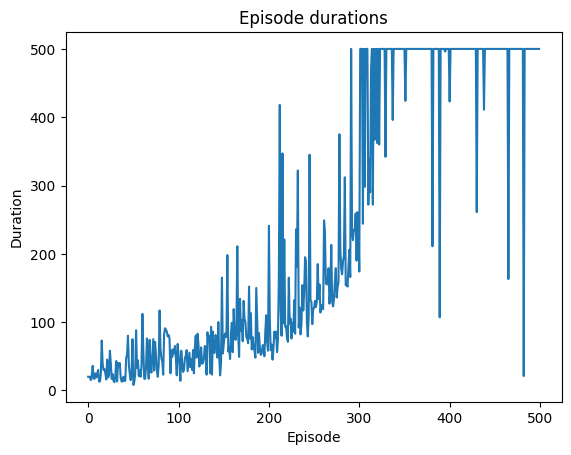

In [54]:
train_model(model, 500, loss_fn, optimizer)

Now let's test the model!

In [55]:
env = gym.make("CartPole-v1", render_mode='human')
observation, _ = env.reset()
terminated, truncated = False, False
while not (terminated or truncated):
    action = select_action(model, observation, train=False)
    observation, reward, terminated, truncated, _ = env.step(action)
env.close()

I also need to save it lol

In [56]:
#torch.save(model.state_dict(), 'CartPole-v1_model1.pth')